[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

This follows what we did previously.

In [1]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [2]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

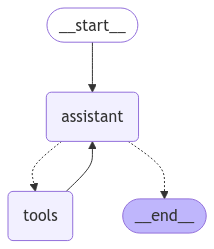

In [3]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## 1. Non memory 에이전트


## Memory

Let's run our agent, as before.

In [4]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_WIgMkr7k8M251Lnhnt5yupnq)
 Call ID: call_WIgMkr7k8M251Lnhnt5yupnq
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


Now, let's multiply by 2!

In [5]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

It seems like you're asking to multiply a number by 2, but I don't have the initial number that you want to multiply. Could you please provide the number you'd like to multiply by 2?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

## 2. memory 에이전트


In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


1. Sequential Nodes (순차적 노드)
    * 순차적으로 실행되는 노드들은 각각 별도의 super-step을 가짐
2. Parallel Nodes (병렬 노드)
    * 동시에 실행되는 병렬 노드들은 같은 super-step을 공유

체크포인트 저장 시점
* 순차 노드 : 각 노드마다 체크포인트 생성
* 병렬 노드 : 모든 병렬 노드가 완료된 후 하나의 체크포인트 생성


In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)

for m in messages['messages']:
    m.pretty_print()

체크포인트 -1
최초 사용자 입력 단계
저장내용: 사용자의 메시지 ("Add 4 and 5.")
__start__ 채널에 초기 메시지 기록
체크포인트 0
대화 초기화 단계
저장내용: 사용자 메시지를 messages 채널로 이동
start:assistant 설정 (AI 응답 준비)
체크포인트 1
AI의 tool 호출 단계
저장내용: AI가 add 툴을 호출하기 위한 준비
tool_calls 정보 (tool: add, 파라미터: a=4, b=5)
토큰 사용량 등 메타데이터
체크포인트 2
툴 실행 결과 단계
저장내용: add 툴의 실행 결과 ("9")
ToolMessage로 결과값 저장
체크포인트 3
AI의 최종 응답 단계
저장내용: AI의 최종 응답 메시지 ("The sum of 4 and 5 is 9.")
전체 대화 완료 상태

In [25]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory_v2 = builder.compile(checkpointer=memory)

In [ ]:
# Specify a thread
config_101 = {"configurable": {"thread_id": "101"}}

# Specify an input
messages = [HumanMessage(content="Add 4 and 5.")]

# Run
messages = react_graph_memory_v2.invoke({"messages": messages},config_101)

# for m in messages['messages']:
#     m.pretty_print()


In [27]:
# 체크포인트 확인
config_101 = {"configurable": {"thread_id": "101"}}

print("\n=== 체크포인트 내용 확인 ===")
for checkpoint_tuple in memory.list(config_101):
    print(f"\n[Checkpoint {checkpoint_tuple.metadata['step']}]")
    print("State:")
    print(checkpoint_tuple.checkpoint)  # 전체 체크포인트 상태 출력
    print("\nMetadata:")
    print(checkpoint_tuple.metadata)
    print("\nParent Config:")
    print(checkpoint_tuple.parent_config)
    print("---")


=== 체크포인트 내용 확인 ===

[Checkpoint 3]
State:
{'v': 1, 'ts': '2024-11-27T03:15:16.135158+00:00', 'id': '1efac6dd-2e41-6b15-8003-05c7af176268', 'channel_values': {'messages': [HumanMessage(content='Add 4 and 5.', additional_kwargs={}, response_metadata={}, id='a0847524-6ebc-4af1-b0cc-c1a940868436'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3wWfIK4HShocDih6rInNaoCT', 'function': {'arguments': '{"a":4,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 132, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a017179d-6800-4c5c-9a3f-4ea8be846ecc-0', tool_calls=[{'name': 'add

In [28]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory_v2.invoke({"messages": messages}, config_101)


print("\n=== 체크포인트 내용 확인 ===")
for checkpoint_tuple in memory.list(config_101):
    print(f"\n[Checkpoint {checkpoint_tuple.metadata['step']}]")
    print("State:")
    print(checkpoint_tuple.checkpoint)  # 전체 체크포인트 상태 출력
    print("\nMetadata:")
    print(checkpoint_tuple.metadata)
    print("\nParent Config:")
    print(checkpoint_tuple.parent_config)
    print("---")


=== 체크포인트 내용 확인 ===

[Checkpoint 8]
State:
{'v': 1, 'ts': '2024-11-27T03:15:59.981831+00:00', 'id': '1efac6de-d069-6452-8008-1bfaeda13008', 'channel_values': {'messages': [HumanMessage(content='Add 4 and 5.', additional_kwargs={}, response_metadata={}, id='a0847524-6ebc-4af1-b0cc-c1a940868436'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3wWfIK4HShocDih6rInNaoCT', 'function': {'arguments': '{"a":4,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 132, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a017179d-6800-4c5c-9a3f-4ea8be846ecc-0', tool_calls=[{'name': 'add

If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [9]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_NcVrcwTmttFPB4gsbIdZetQv)
 Call ID: call_NcVrcwTmttFPB4gsbIdZetQv
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_SzdULNkRWxM8HxfzZSs6QusQ)
 Call ID: call_SzdULNkRWxM8HxfzZSs6QusQ
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.